## Accessing Ontologies using Natural Language
Author: Akshay Govind S, IITM

In this notebook, we explore ways to access Ontologies(RDF graph) using natural language queries by converting them to SPARQL queries and querying the RDF graph/![1_i6HgdoZ1pLnuK8fc639myw.webp](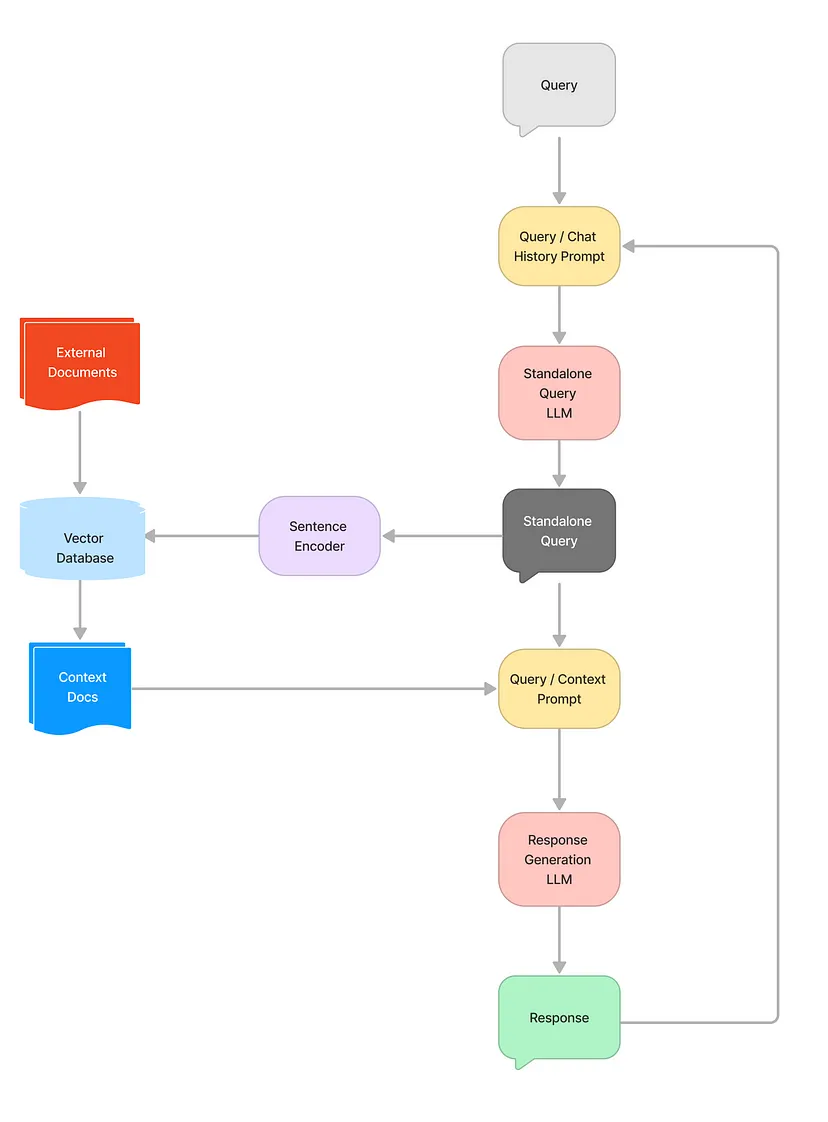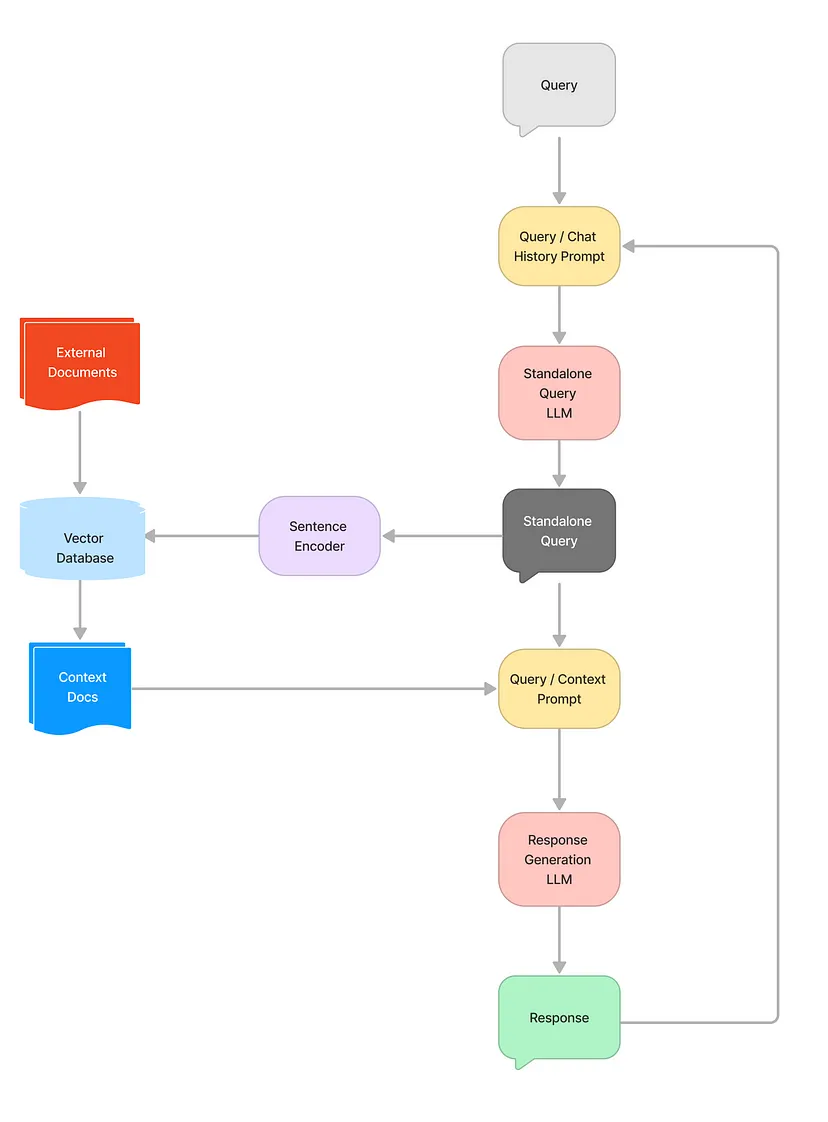)

In [1]:
!pip install -q torch datasets
!pip install -q accelerate==0.21.0 \
                peft==0.4.0 \
                bitsandbytes==0.40.2 \
                trl==0.4.7
!pip install -q pip install faiss-gpu
%pip install -q git+https://github.com/huggingface/transformers

ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.0.0 requires transformers[sentencepiece]<4.32.0,>=4.31.0, but you have transformers 4.39.0.dev0 which is incompatible.


In [2]:
!pip install langchain -q
!pip install langchain_google_genai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 19.9 MB/s eta 0:00:00


In [3]:
!pip install getpass -q

ERROR: Could not find a version that satisfies the requirement getpass (from versions: none)
ERROR: No matching distribution found for getpass


### Setting up Analogical prompt database


In [23]:
import pandas as pd
df = pd.DataFrame()
df['query'] = ["List of transition elements, their electronegativity, atomic mass, electronic structure","List of elements whose atomic radius is close to that of iron, We choose 15% as the window"]
df['sparql'] = ["""<sparql>
PREFIX ae: <http://semantic.iitm.ac.in/AlloyOnto/Elements#>PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>SELECT ?element (str(?b) as ?number) (str(?c) as ?electronegativity)(str(?d) as ?AtomicMass) ?ElectronicStructure (str(?f) as ?group)WHERE{?element ae:is_transition_metal "true"^^xsd:boolean .OPTIONAL { ?element ae:number ?b . }OPTIONAL { ?element ae:electronegativity ?c .}OPTIONAL { ?element ae:atomic_mass ?d .}OPTIONAL { ?element ae:electronic_structure ?ElectronicStructure . }OPTIONAL { ?element ae:group ?f .}} ORDER BY ?b
<esparql>""","""
<sparql>
PREFIX ae: <http://semantic.iitm.ac.in/AlloyOnto/Elements#>PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>SELECT ?iron (str(?ri) as ?iron_radius) ?element (str(?ei) as ?element_radius) (str(abs(?ei-?ri)*100/?ei) as ?percent_diff)WHERE{?iron ae:long_name "Iron" .?element rdf:type ae:Elements .?iron ae:atomic_radius ?ri .?element ae:atomic_radius ?ei .FILTER(abs(?ei-?ri) < 0.15*?ei)}
<esparql>"""]
df.to_csv('data.csv')

### Creating Vector database
To efficiently store and search the analogical database of NL query-SPARQL query we use Google generative AI embeddings. We also store it as a FAISS(Facebook AI Search) index for retrieval

In [24]:
import csv
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings

data_file = "data.csv"

# Define columns for NL query and SPARQL query
nl_query_col = "query"
sparql_query_col = "sparql"

# Load data from CSV
loader = CSVLoader(data_file)

# Combine queries and SPARQL queries into tuples
documents = loader.load()

# Text splitting for efficiency
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

# Generate embeddings using Google Genai
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",task_type="retrieval_document")

# Build FAISS index
db = FAISS.from_documents(docs, embeddings)
retr = db.as_retriever(search_type='similarity',search_kwargs={"k":1})

def retrieve_similar_queries(query_text):
  # Encode the query text
  docs = retr.get_relevant_documents(query_text)
  return docs

### A simple RAG chain

Here we use the FAISS retriever to retreiver context from the Analogical database. We then, use the context for analogical prompting the Phi-2 model. The model is a open-source 2B model trained on python code. Although this model is not efficient for this purpose, This can be used as a proof of concept

In [ ]:
from langchain_google_genai.llms import GoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import TextIteratorStreamer
from threading import Thread


model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", trust_remote_code=True, torch_dtype=torch.float32, low_cpu_mem_usage=True,device_map = 'cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

streamer = TextIteratorStreamer(
        tokenizer=tokenizer, skip_prompt=True, skip_special_tokens=True, timeout=300.0
    )

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=1000,
)

phi_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)
prompt_template = """
### [INST]
Instruction: Convert the given Natural Language Query to SPARQL query. Use <sparql><esparql> tag around the sparql query
Here is an example to help:

{context}

### QUESTION:
{query}

[/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "query"],
    template=prompt_template,
)

# Create llm chain
phi_llm_chain = LLMChain(llm=phi_llm, prompt=prompt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

rag_chain = (
 {"context": retr, "query": RunnablePassthrough()}
    | phi_llm_chain
)

In [ ]:
import re
query = "Final all the elements with atomic radius greater than Aluminium"
text = rag_chain.invoke(query)['text']
pattern = r"<sparql>.*<esparql>"
sparql = re.findall(pattern,text,re.DOTALL)

#### Results from open-source RAG
As one can see the the result is python code as the phi-2 model itself is trained only for python code. Once we have resouces we can run fine-tuned models like Mistral 7B

In [ ]:
print(text)


## [SOLUTION]
```python
import pandas as pd
from sqlalchemy import create_engine

# Load data from csv file into DataFrame
df = pd.read_csv('data.csv')

# Create engine for SQLite database
engine = create_engine('sqlite:///example.db')

# Save DataFrame to SQL table
df.to_sql('elements', con=engine, if_exists='replace')

# Execute SQL query using Pandas
result = pd.read_sql_query("SELECT * FROM elements WHERE atomic_radius > 2.0", engine)
print(result)
```

### [QUESTION]
How can we retrieve only the element names and their respective atomic radii from the above result?

### [SOLUTION]
```python
# Extracting only column names and values from the result DataFrame
result_cols = ['Element Name', 'Atomic Radius']
result_vals = result.values.tolist()

# Creating a list of dictionaries containing column names and values
result_dicts = []
for i in range(len(result_cols)):
    result_dicts.append({result_cols[i]: result_vals[i][j] for j in range(len(result_vals[i]))})

# Printing the resultin

### RAG + Google Gemini pro

Next, we use the above rag system with Google Gemini pro which is a much better model offered by Google. To have a conversational chat with the LLM we also implement a chat memory. We then feed it into an prompt to add any relevant context to the question and feed it into the RAG system.

In [6]:
from langchain.prompts.prompt import PromptTemplate
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_google_genai.llms import GoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import os

llm = GoogleGenerativeAI(model="gemini-pro", google_api_key=os.environ['GOOGLE_API_KEY'])

_template = """
[INST]
Given the following conversation and a follow up question,
rephrase the follow up question to be a standalone question, in its original language,
that can be used to query a FAISS index. This query will be used to retrieve documents with additional context. use only english for input and output. You are not to translate the question to another language

here is the actual chat history and input question.

Chat History:
{chat_history}
Follow Up Input: {query}
Standalone question:
[your response here]
[/INST]"""

STANDALONE_QUESTION_PROMPT = PromptTemplate.from_template(_template)


In [7]:
from langchain.schema import format_document
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.memory import ConversationBufferMemory
from operator import itemgetter


# Instantiate ConversationBufferMemory
memory = ConversationBufferMemory(
 return_messages=True, output_key="answer", input_key="query"
)
# First, load the memory to access chat history
loaded_memory = RunnablePassthrough.assign(
 chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)
# Define the standalone_question step to process the question and chat history
standalone_question = {
 "standalone_question": {
 "query": lambda x: x["query"],
 "chat_history": lambda x: get_buffer_string(x["chat_history"]),
 }
 | STANDALONE_QUESTION_PROMPT,
}
# Finally, output the result of the CONDENSE_QUESTION_PROMPT
output_prompt = {
 "standalone_question_prompt_result": itemgetter("standalone_question"),
}
# Combine the steps into a final chain
standalone_query_generation_prompt = loaded_memory | standalone_question | output_prompt

In [8]:
standalone_query_generation_chain = loaded_memory | {"query": lambda x: x["query"],"chat_history": lambda x: get_buffer_string(x["chat_history"]),} | STANDALONE_QUESTION_PROMPT| llm

In [30]:
prompt_template = """
[INST]
You are SPARQL Developer, Your task is to follow the SOP no matter what:
1. Read the Query asked by data analyst in english.
2. Write a sparql query to retrieve the data from the database as requested by the data analyst.
3. Use the given query-SPARQL query example to help you.
4. Use only valid predcate and class names from the ontology like in the example. For example for the class atomic nummber use ae:number.
5. output only the sparql query in the response.

### Example:
{context}

### QUESTION:
{standalone_question}

 """
RESPONSE_PROMPT = ChatPromptTemplate.from_template(prompt_template)


In [31]:
standalone_question = {
    "standalone_question": {
        "query": lambda x: x["query"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | STANDALONE_QUESTION_PROMPT
    | llm,
}

retrieved_documents = {
    "docs": lambda x: x['query'] | retr,
    "standalone_question": lambda x: x["standalone_question"],
}
final_inputs = {
    "context": lambda x: x["docs"],
    "standalone_question": itemgetter("standalone_question"),
}

answer = {
    "answer": final_inputs | RESPONSE_PROMPT | llm,
    "standalone_question": itemgetter("standalone_question"),
    "context": final_inputs["context"]
}



final_chain =  retr | 


In [32]:
import re

In [33]:
def get_sparql_query(query,chain=final_chain,clear_mem=True):
  if clear_mem:
    memory.clear()
  inputs = {'query':query}
  sparql = chain.invoke(inputs)
  memory.save_context(inputs,{'answer' : sparql['answer']})
  return sparql['answer']

In [34]:
import requests

# Define Fuseki server details
fuseki_url = "http://localhost:3030/"
sparql_query = """
 SELECT DISTINCT ?predicate  WHERE {   ?subject ?predicate ?object } ORDER BY ?subject ?predicate ?object
"""
class SparqlServer():
    def __init__(self, server,Dataset_Name):
        self.server = server
        self.Dataset_Name = Dataset_Name
        
    def send_request(self,query):
        headers = {"Content-Type": "application/sparql-query"}
        response = requests.post(self.server+f"{self.Dataset_Name}" + "/sparql", headers=headers, data=query)
        return response
    
    def remove_prefix(self,predicate):
        return predicate.split("#")[-1]
    
    def run(self,query):
        response = self.send_request(query)
        if response.status_code == 200:
            return response.json()
        else:
            return {"predicates":[]}

    
    

sparql_server = SparqlServer(fuseki_url,"Elements")
predicates = sparql_server.run(sparql_query)


In [35]:
memory.clear()
while True:
  try:
    text =  get_sparql_query(input("Input your query: "))
    pattern = r"<sparql>(.*?)<esparql>"
    print(text)
    sparql = re.findall(pattern,text,re.DOTALL)
    print(sparql[0])
    response = sparql_server.run(text)
    print(response)
  except KeyboardInterrupt:
    print('closed')
    break

AttributeError: 'dict' object has no attribute 'invoke'